In [1]:
import matplotlib.pyplot as plt
import pvlib

import cpvlib
from parametros import mod_params_cpv, mod_params_diffuse, params_tracker

In [2]:
IN_TRACKER = False

lat, lon = 40.4, -3.7

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

data = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=695, tz='utc')

solar_zenith = location.get_solarposition(data.index).zenith
solar_azimuth = location.get_solarposition(data.index).azimuth

StaticHybridSystem

In [3]:
static_hybrid_sys = cpvlib.StaticHybridSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_cpv=None,
    module_diffuse=None,
    module_parameters_cpv=mod_params_cpv,
    module_parameters_diffuse=mod_params_diffuse,
    in_tracker=IN_TRACKER,
    parameters_tracker=params_tracker,
    modules_per_string=1,
    strings_per_inverter=1,
    inverter=None,
    inverter_parameters=None,
    racking_model="insulated",
    losses_parameters=None,
    name=None,
)

get_effective_irradiance

In [4]:
data['dii_effective'], data['poa_diffuse_static_effective'] = static_hybrid_sys.get_effective_irradiance(
    solar_zenith,
    solar_azimuth,
    iam_param=0.7,
    aoi_limit=55,
    dii=None,
    ghi=data['ghi'],
    dhi=data['dhi'],
    dni=data['dni']
)

pvsyst_celltemp

In [5]:
data['temp_cell_35'], data['temp_cell_diffuse'] = static_hybrid_sys.pvsyst_celltemp(
    dii=data['dii_effective'],
    poa_diffuse_static=data['poa_diffuse_static_effective'],
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

C:\Users\Ruben\Documents\GitHub\cpvlib\cpvlib.py:181: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)
C:\Users\Ruben\Documents\GitHub\cpvlib\cpvlib.py:597: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


calcparams_pvsyst

In [6]:
diode_parameters_cpv, diode_parameters_diffuse = static_hybrid_sys.calcparams_pvsyst(
    dii=data['dii_effective'],
    poa_diffuse_static=data['poa_diffuse_static_effective'],
    temp_cell_cpv=data['temp_cell_35'],
    temp_cell_diffuse=data['temp_cell_diffuse'],
)

singlediode

In [7]:
dc_cpv, dc_diffuse = static_hybrid_sys.singlediode(
    diode_parameters_cpv, diode_parameters_diffuse)

uf_global (uf_am, uf_temp_air)

In [8]:
airmass_absolute = location.get_airmass(data.index).airmass_absolute

uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(airmass_absolute, data['temp_air'],
                                                                  solar_zenith, solar_azimuth)

UF_am - Plot

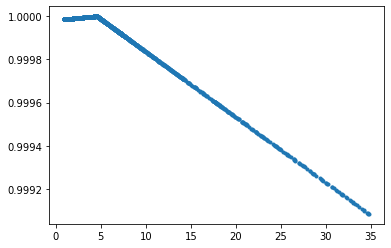

In [9]:
UF_am = cpvlib.get_simple_util_factor(airmass_absolute, thld=mod_params_cpv['am_thld'], m_low=mod_params_cpv['am_uf_m_low'], m_high=mod_params_cpv['am_uf_m_high'])
plt.plot(airmass_absolute, UF_am, '.')

Energia

In [10]:
print('\nTracker?', static_hybrid_sys.in_tracker)

energia_cpv = (dc_cpv['p_mp'] * uf_cpv).sum()
energia_difusa = dc_diffuse['p_mp'].sum()

print(f"E_CPV={energia_cpv}", f"E_diff={energia_difusa}")


Tracker? False
E_CPV=28326.567022520583 E_diff=8881.36661459171
